<a href="https://colab.research.google.com/github/bhardwajshivam/Deep-Q-learning-for-Finance/blob/main/Deep_Q_Learning_for_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q Learning for finance

In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
%config InlineBackend.figure_format = 'svg'

<ipython-input-1-eabaf03f8e47>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
import warnings as w
w.simplefilter('ignore')

In [ ]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'


In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [ ]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score

In [ ]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    env.action_space.seed(100)


## Q-Learning


In [ ]:
from collections import deque

In [ ]:
class DQLAgent:
    def __init__(self, gamma=0.95, hu=24, opt=keras.optimizers.legacy.Adam,
           lr=0.001, finish=False):
        self.finish = finish
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = gamma
        self.batch_size = 32
        self.max_treward = 0
        self.averages = list()
        self.memory = deque(maxlen=2000)
        self.osn = env.observation_space.shape[0]
        self.model = self._build_model(hu, opt, lr)

    def _build_model(self, hu, opt, lr):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.osn,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=opt(learning_rate=lr))
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        action = self.model.predict(state)[0]
        return np.argmax(action)

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0])
            target = self.model.predict(state)
            target[0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()
            state = np.reshape(state, [1, self.osn])
            for _ in range(5000):
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.osn])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    av = sum(trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:4d} | '
                    templ += 'av: {:6.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, av,
                                       self.max_treward), end='\r')
                    break
            if av > 195 and self.finish:
                break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()
    def test(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()
            for _ in range(5001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model.predict(state)[0])
                next_state, reward, done, info = env.step(action)
                state = next_state
                if done:
                    treward = _ + 1
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:4d}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

## Finance environment

In [ ]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [ ]:
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        random.seed(seed)
    def sample(self):
        return random.randint(0, self.n - 1)

In [ ]:
class Finance:

    def __init__(self, symbol, features):
        self.symbol = symbol
        self.features = features
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(2)
        self.min_accuracy = 0.475
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
    def _get_state(self):
        return self.data[self.features].iloc[
            self.bar - self.osn:self.bar].values
    def seed(self, seed=None):
        pass
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.osn
        state = self.data[self.features].iloc[
            self.bar - self.osn:self.bar]
        return state.values
    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.osn)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.osn + 10):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state, reward, done, info

In [ ]:
env = Finance('EUR=', 'EUR=')  # price as feature

In [ ]:

env = Finance('EUR=', 'r')  # log return as feature

In [ ]:
env.reset()


array([-0.5125,  0.5603, -1.1434,  1.1788])

In [ ]:
a = env.action_space.sample()
a

0

In [ ]:
env.step(a)

(array([ 0.5603, -1.1434,  1.1788,  1.2569]), 0, False, {})

In [ ]:
set_seeds(100)
agent = DQLAgent(gamma=0.5, opt=keras.optimizers.legacy.RMSprop)

In [ ]:
episodes = 300

In [ ]:
%time agent.learn(episodes)


CPU times: user 6min 5s, sys: 14.7 s, total: 6min 20s
Wall time: 6min 5s


In [ ]:
agent.epsilon


0.22453190559909803

In [ ]:
agent.test(3)

[2511, 2511, 2511]

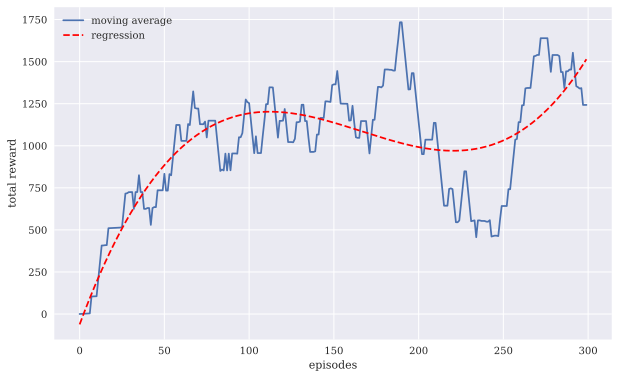

In [ ]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

# Improve Finance environement

In [ ]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        pass
    def sample(self):
        return random.randint(0, self.n - 1)

In [ ]:
class Finance:

    def __init__(self, symbol, features, window, lags,
                 leverage=1, min_performance=0.85,
                 start=0, end=None, mu=None, std=None):
        self.symbol = symbol
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.observation_space = observation_space(self.lags)
        self.action_space = action_space(2)
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()
    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data = self.data.iloc[self.start:]
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data['s'] = self.data[self.symbol].rolling(
                                              self.window).mean()
        self.data['m'] = self.data['r'].rolling(self.window).mean()
        self.data['v'] = self.data['r'].rolling(self.window).std()
        self.data.dropna(inplace=True)
        if self.mu is None:
            self.mu = self.data.mean()
            self.std = self.data.std()
        self.data_ = (self.data - self.mu) / self.std
        self.data_['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data_['d'] = self.data_['d'].astype(int)
        if self.end is not None:
            self.data = self.data.iloc[:self.end - self.start]
            self.data_ = self.data_.iloc[:self.end - self.start]
    def _get_state(self):
        return self.data_[self.features].iloc[self.bar -
                                self.lags:self.bar]
    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data_[self.features].iloc[self.bar-
                        self.lags:self.bar]
        return state.values
    def step(self, action):
        correct = action == self.data_['d'].iloc[self.bar]
        ret = self.data['r'].iloc[self.bar] * self.leverage
        reward_1 = 1 if correct else 0
        reward_2 = abs(ret) if correct else -abs(ret)
        self.treward += reward_1
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(reward_2)
        if self.bar >= len(self.data):
            done = True
        elif reward_1 == 1:
            done = False
        elif (self.performance < self.min_performance and
              self.bar > self.lags + 15):
            done = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state.values, reward_1 + reward_2 * 252, done, info


In [ ]:
env = Finance('EUR=', ['EUR=', 'r', 'v'], window=10, lags=5)
a = env.action_space.sample()
a

1

In [ ]:
env.reset()

array([[ 1.7721, -1.0214,  0.0351],
       [ 1.5973, -2.4432,  0.6954],
       [ 1.5876, -0.1208,  0.6   ],
       [ 1.6292,  0.6083,  0.6123],
       [ 1.6408,  0.1807,  0.3693]])

In [ ]:
env.step(a)

(array([[ 1.5973, -2.4432,  0.6954],
        [ 1.5876, -0.1208,  0.6   ],
        [ 1.6292,  0.6083,  0.6123],
        [ 1.6408,  0.1807,  0.3693],
        [ 1.5725, -0.9502,  0.0035]]),
 -1.3750521308536245,
 False,
 {})

#Improved Financical QL Agent

In [ ]:
class FQLAgent:
    def __init__(self, hidden_units, learning_rate, learn_env, valid_env, dropout=True):
        self.learn_env = learn_env
        self.valid_env = valid_env
        self.dropout = dropout
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.98
        self.learning_rate = learning_rate
        self.gamma = 0.95
        self.batch_size = 128
        self.max_treward = 0
        self.trewards = list()
        self.averages = list()
        self.performances = list()
        self.aperformances = list()
        self.vperformances = list()
        self.memory = deque(maxlen=2000)
        self.model = self._build_model(hidden_units, learning_rate)

    def _build_model(self, hu, lr):
        model = Sequential()
        model.add(Dense(hu, input_shape=(
            self.learn_env.lags, self.learn_env.n_features),
                        activation='relu'))
        if self.dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(hu, activation='relu'))
        if self.dropout:
            model.add(Dropout(0.3, seed=100))
        model.add(Dense(2, activation='linear'))
        model.compile(
            loss='mse',
            optimizer=keras.optimizers.RMSprop(learning_rate=lr)
        )
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.learn_env.action_space.sample()
        action = self.model.predict(state)[0, 0]
        return np.argmax(action)

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0, 0])
            target = self.model.predict(state)
            target[0, 0, action] = reward
            self.model.fit(state, target, epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = self.learn_env.reset()
            state = np.reshape(state, [1, self.learn_env.lags,
                                       self.learn_env.n_features])
            for _ in range(10000):
                action = self.act(state)
                next_state, reward, done, info = \
                                self.learn_env.step(action)
                next_state = np.reshape(next_state,
                                [1, self.learn_env.lags,
                                 self.learn_env.n_features])
                self.memory.append([state, action, reward,
                                     next_state, done])
                state = next_state
                if done:
                    treward = _ + 1
                    self.trewards.append(treward)
                    av = sum(self.trewards[-25:]) / 25
                    perf = self.learn_env.performance
                    self.averages.append(av)
                    self.performances.append(perf)
                    self.aperformances.append(
                        sum(self.performances[-25:]) / 25)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:2d}/{} | treward: {:4d} | '
                    templ += 'perf: {:5.3f} | av: {:5.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, perf,
                                  av, self.max_treward), end='\r')
                    break
            self.validate(e, episodes)
            if len(self.memory) > self.batch_size:
                self.replay()
        print()
    def validate(self, e, episodes):
        state = self.valid_env.reset()
        state = np.reshape(state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
        for _ in range(10000):
            action = np.argmax(self.model.predict(state)[0, 0])
            next_state, reward, done, info = self.valid_env.step(action)
            state = np.reshape(next_state, [1, self.valid_env.lags,
                                   self.valid_env.n_features])
            if done:
                treward = _ + 1
                perf = self.valid_env.performance
                self.vperformances.append(perf)
                if e % 20 == 0:
                    templ = 71 * '='
                    templ += '\nepisode: {:2d}/{} | VALIDATION | '
                    templ += 'treward: {:4d} | perf: {:5.3f} | '
                    templ += 'eps: {:.2f}\n'
                    templ += 71 * '='
                    print(templ.format(e, episodes, treward,
                                       perf, self.epsilon))
                break

In [ ]:
symbol = 'EUR='
features = ['r', 's', 'm', 'v']
a = 0
b = 2000
c = 500

In [ ]:
learn_env = Finance(symbol, features, window=10, lags=6,
                 leverage=1, min_performance=0.85,
                 start=a, end=a + b, mu=None, std=None)
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2010-01-19 to 2017-12-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2000 non-null   float64
 1   r       2000 non-null   float64
 2   s       2000 non-null   float64
 3   m       2000 non-null   float64
 4   v       2000 non-null   float64
dtypes: float64(5)
memory usage: 93.8 KB


In [ ]:
valid_env = Finance(symbol, features, window=learn_env.window,
                 lags=learn_env.lags, leverage=learn_env.leverage,
                 min_performance=learn_env.min_performance,
                 start=a + b, end=a + b + c,
                 mu=learn_env.mu, std=learn_env.std)
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2017-12-27 to 2019-12-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    500 non-null    float64
 1   r       500 non-null    float64
 2   s       500 non-null    float64
 3   m       500 non-null    float64
 4   v       500 non-null    float64
dtypes: float64(5)
memory usage: 23.4 KB


In [ ]:
set_seeds(100)
agent = FQLAgent(48, 0.0001, learn_env, valid_env, True)
episodes = 61

In [ ]:
%time agent.learn(episodes)


episode: 20/61 | VALIDATION | treward:  494 | perf: 1.064 | eps: 0.68
episode: 40/61 | VALIDATION | treward:  494 | perf: 1.089 | eps: 0.45
episode: 60/61 | VALIDATION | treward:  494 | perf: 1.089 | eps: 0.30

CPU times: user 6min 34s, sys: 22.5 s, total: 6min 57s
Wall time: 5min 42s


In [ ]:
agent.epsilon

0.291602079838278

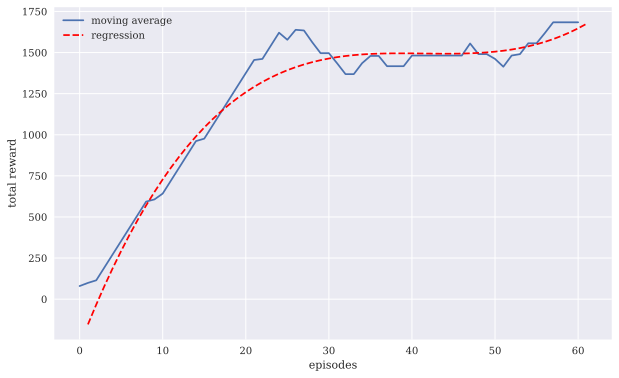

In [ ]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.averages) + 1)
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend();

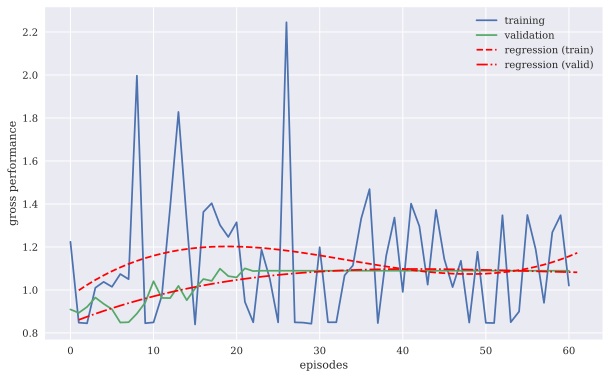

In [ ]:
plt.figure(figsize=(10, 6))
x = range(1, len(agent.performances) + 1)
y = np.polyval(np.polyfit(x, agent.performances, deg=3), x)
y_ = np.polyval(np.polyfit(x, agent.vperformances, deg=3), x)
plt.plot(agent.performances[:], label='training')
plt.plot(agent.vperformances[:], label='validation')
plt.plot(x, y, 'r--', label='regression (train)')
plt.plot(x, y_, 'r-.', label='regression (valid)')
plt.xlabel('episodes')
plt.ylabel('gross performance')
plt.legend();


(array([[ 1.5876, -0.1208,  0.6   ],
        [ 1.6292,  0.6083,  0.6123],
        [ 1.6408,  0.1807,  0.3693],
        [ 1.5725, -0.9502,  0.0035],
        [ 1.5228, -0.6896, -0.0114]]),
 -1.0047717120445376,
 False,
 {})

Episode 26 Parameters:
Total Reward: 918
Performance: 0.8491437895042537
Rolling Average: 1577.72
Max Total Reward So Far: 1994
